.## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading Data from Drive

In [ ]:
!gdown 18T123hJ3qT3QTDqeeJlY07JtJa6vnqVv

Downloading...
From (original): https://drive.google.com/uc?id=18T123hJ3qT3QTDqeeJlY07JtJa6vnqVv
From (redirected): https://drive.google.com/uc?id=18T123hJ3qT3QTDqeeJlY07JtJa6vnqVv&confirm=t&uuid=81f9998a-7afb-4515-a747-6788895b0408
To: /content/archive.zip
100% 42.6M/42.6M [00:00<00:00, 130MB/s]


In [ ]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: drugsComTest_raw.csv    
  inflating: drugsComTrain_raw.csv   


## Data Preprocessing

### Intializing datasets


In [ ]:
import pandas as pd # Reading Csv files

In [ ]:
# Intializing both training and test datasets
train_df = pd.read_csv("/content/drugsComTrain_raw.csv")
test_df = pd.read_csv("/content/drugsComTest_raw.csv")

# Combining Both datasets for reccomendation model
Data_df = pd.concat((train_df,test_df),ignore_index=False,sort=False)

# Removing the coloumns that are not needed for training model
train_df = train_df.drop(['uniqueID','drugName','rating','date','usefulCount'],axis=1)
test_df = test_df.drop(['uniqueID','drugName','rating','date','usefulCount'],axis=1)

In [ ]:
train_df.head()

,condition,review
0,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati..."
1,ADHD,"""My son is halfway through his fourth week of ..."
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
4,Opiate Dependence,"""Suboxone has completely turned my life around..."


### Data Visualization

In [ ]:
import matplotlib.pyplot as plt

<ipython-input-8-2442d082bbd4>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(smallest.index, rotation=90)


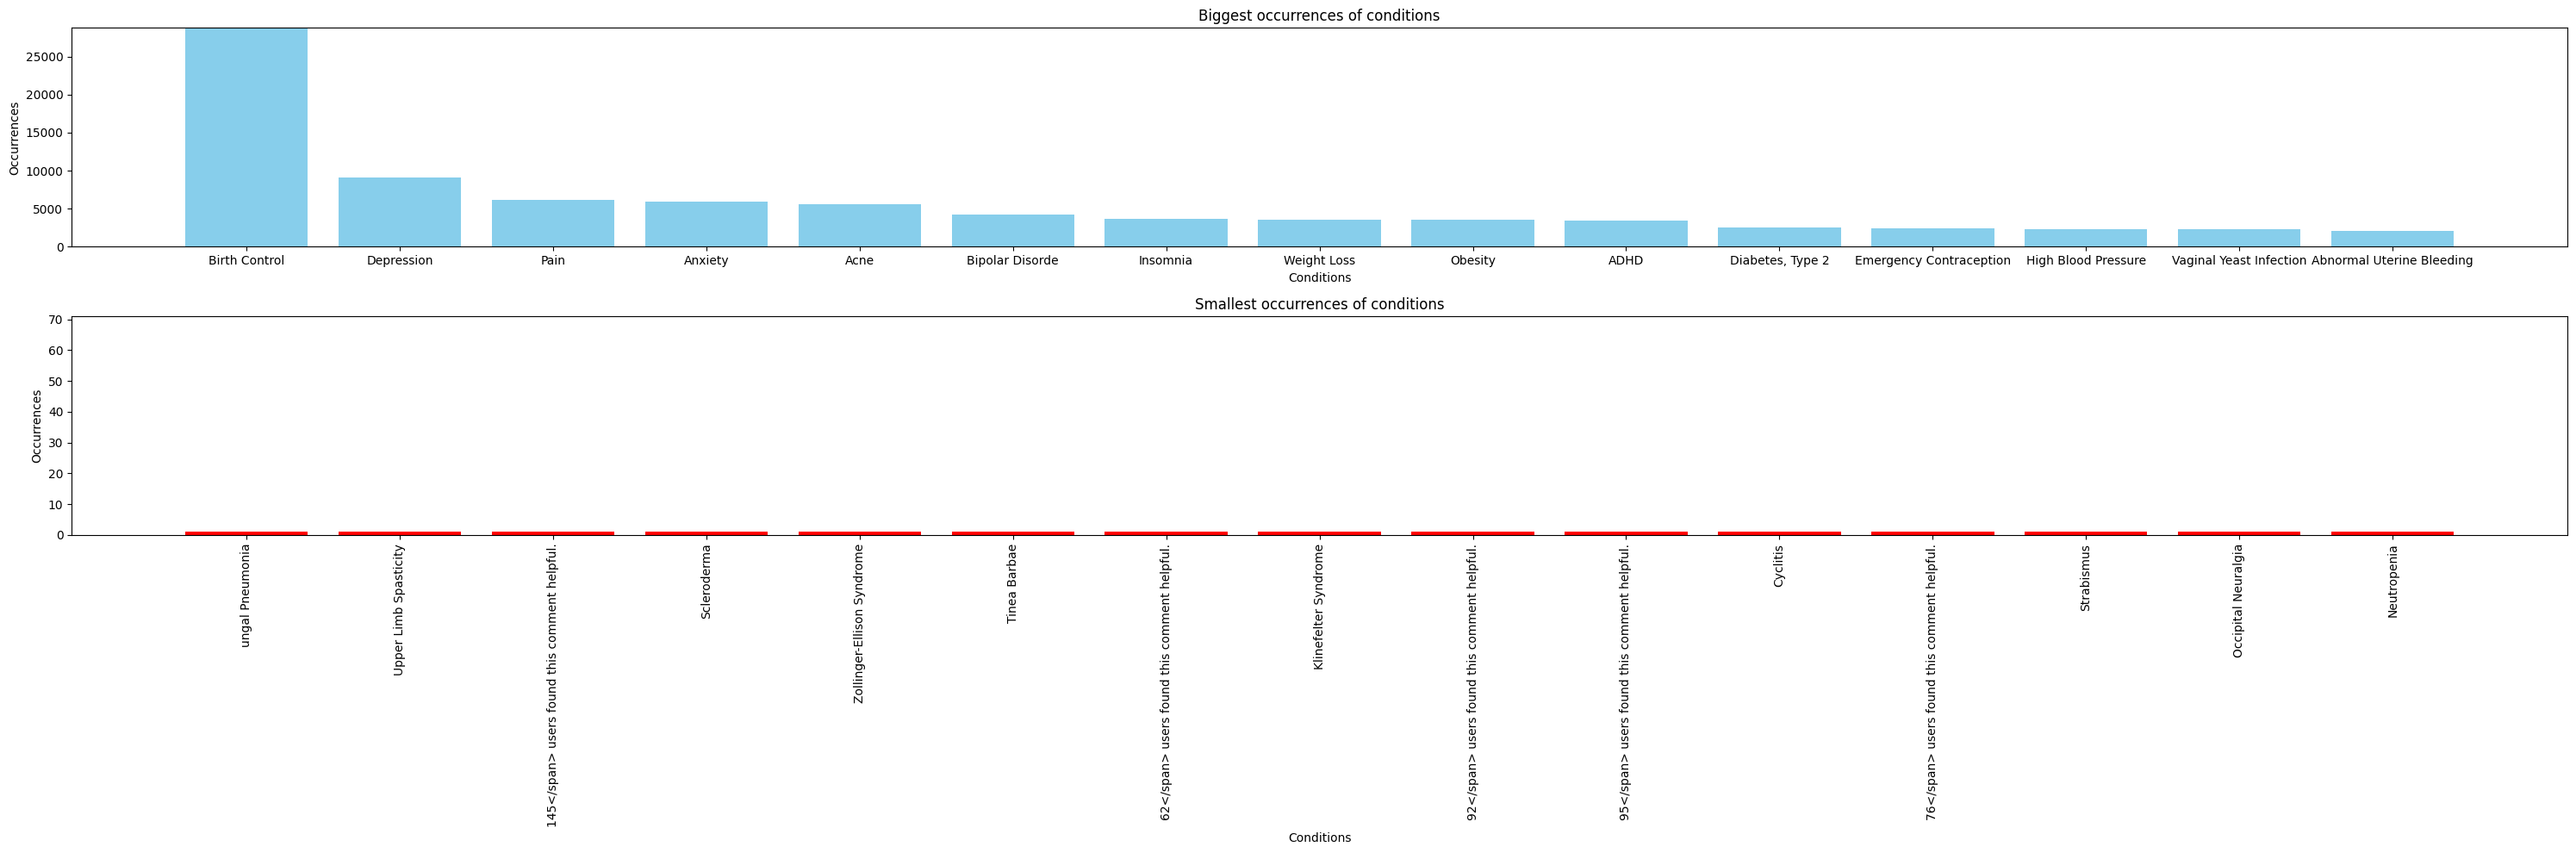

In [ ]:
label_counts = train_df['condition'].value_counts()
label_counts = label_counts.sort_values(ascending=False)

biggest = label_counts[:15]
smallest = label_counts[-15:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))

ax1.bar(biggest.index, biggest.values, color='skyblue')
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Occurrences')
ax1.set_title('Biggest occurrences of conditions')
ax1.set_ylim(0, max(15, biggest[0]))

ax2.bar(smallest.index, smallest.values, color='red')
ax2.set_xlabel('Conditions')
ax2.set_ylabel('Occurrences')
ax2.set_title('Smallest occurrences of conditions')
ax2.set_ylim(0, max(15, biggest[0]//400))
ax2.set_xticklabels(smallest.index, rotation=90)

plt.tight_layout()
plt.show()

### Data Cleaning

In [ ]:
import nltk
import string # Used for cleaning punctuation
from gensim.parsing.preprocessing import remove_stopwords #used to remove stop words (unlike nltk it considers however as a stopword)
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup # Used for Removing HTML tags
#Downloading Word datasets used in lemmatization
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess(data):
   lemmatizer = WordNetLemmatizer()
   temptxt = BeautifulSoup(data, 'html.parser').get_text()

   temptxt= temptxt.translate(str.maketrans('', '', string.punctuation)) #Removes punctuations from string

   temptxt= temptxt.lower() #Applies lowercase to the entire review string

   temptxt= remove_stopwords(temptxt) #Removes stopwords from the review string

   word_list = word_tokenize(temptxt) #Transforms review from String to a 1d array where each word is an element to lemmatize seperatly
   clean_words= ' '.join([lemmatizer.lemmatize(w) for w in word_list])

   return clean_words

# Removing double qoutes
def remove_qoutes(X):
  for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

  return X

# Applying Preprocessing fucntion to both training and test datasets

train_df=remove_qoutes(train_df)
test_df=remove_qoutes(test_df)

train_df['review'] = train_df['review'].apply(preprocess)
test_df['review'] = test_df['review'].apply(preprocess)


<ipython-input-10-09dd2023b8ef>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  temptxt = BeautifulSoup(data, 'html.parser').get_text()
<ipython-input-10-09dd2023b8ef>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  temptxt = BeautifulSoup(data, 'html.parser').get_text()


In [ ]:
# Checking value counts of condtion to set a minimum for our data
train_df.condition.value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

In [ ]:
# Filtering the datasets to only condtions with 3000+ reviews
train_clean_df =train_df.groupby("condition").filter(lambda x: len(x) >= 3000)

# Get all unique target labels
unique_labels = train_clean_df.condition.unique()

test_clean_df=test_df.loc[test_df["condition"].isin(unique_labels)]

In [ ]:
train_clean_df.condition.value_counts()

condition
Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: count, dtype: int64

### Labeling process

In [ ]:
value_pair= {}
for i in range(0,len(unique_labels)):
  value_pair[unique_labels[i]]=i

value_pair

{'ADHD': 0,
 'Birth Control': 1,
 'Bipolar Disorde': 2,
 'Depression': 3,
 'Obesity': 4,
 'Insomnia': 5,
 'Pain': 6,
 'Anxiety': 7,
 'Acne': 8,
 'Weight Loss': 9}

In [ ]:
# Function to add label to Datasets
def labeling(condition):
  label=value_pair[condition]
  return label

train_clean_df["label"]=train_clean_df["condition"].apply(labeling)

test_clean_df["label"]=test_clean_df["condition"].apply(labeling)

<ipython-input-15-7c5bfa318ca6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean_df["label"]=test_clean_df["condition"].apply(labeling)


In [ ]:
train_clean_df.head()

,condition,review,label
1,ADHD,son halfway fourth week intuniv concerned bega...,0
2,Birth Control,oral contraceptive 21 pill cycle happy light p...,1
3,Birth Control,time form birth control im glad went patch 8 m...,1
7,Bipolar Disorde,abilify changed life hope zoloft clonidine sta...,2
9,Birth Control,pill year doctor changed rx chateal effective ...,1


### Data Preperation

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
class Preprocessing(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        Review = str(self.data.review[index])
        Review = " ".join(Review.split())
        inputs = self.tokenizer.encode_plus(
            Review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.label[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
train_clean_df,test_clean_df = train_clean_df.reset_index(drop=True), test_clean_df.reset_index(drop=True)

In [ ]:
training_set = Preprocessing(train_clean_df, tokenizer, MAX_LEN)
testing_set = Preprocessing(test_clean_df, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Recommendation System

In [ ]:
Data_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


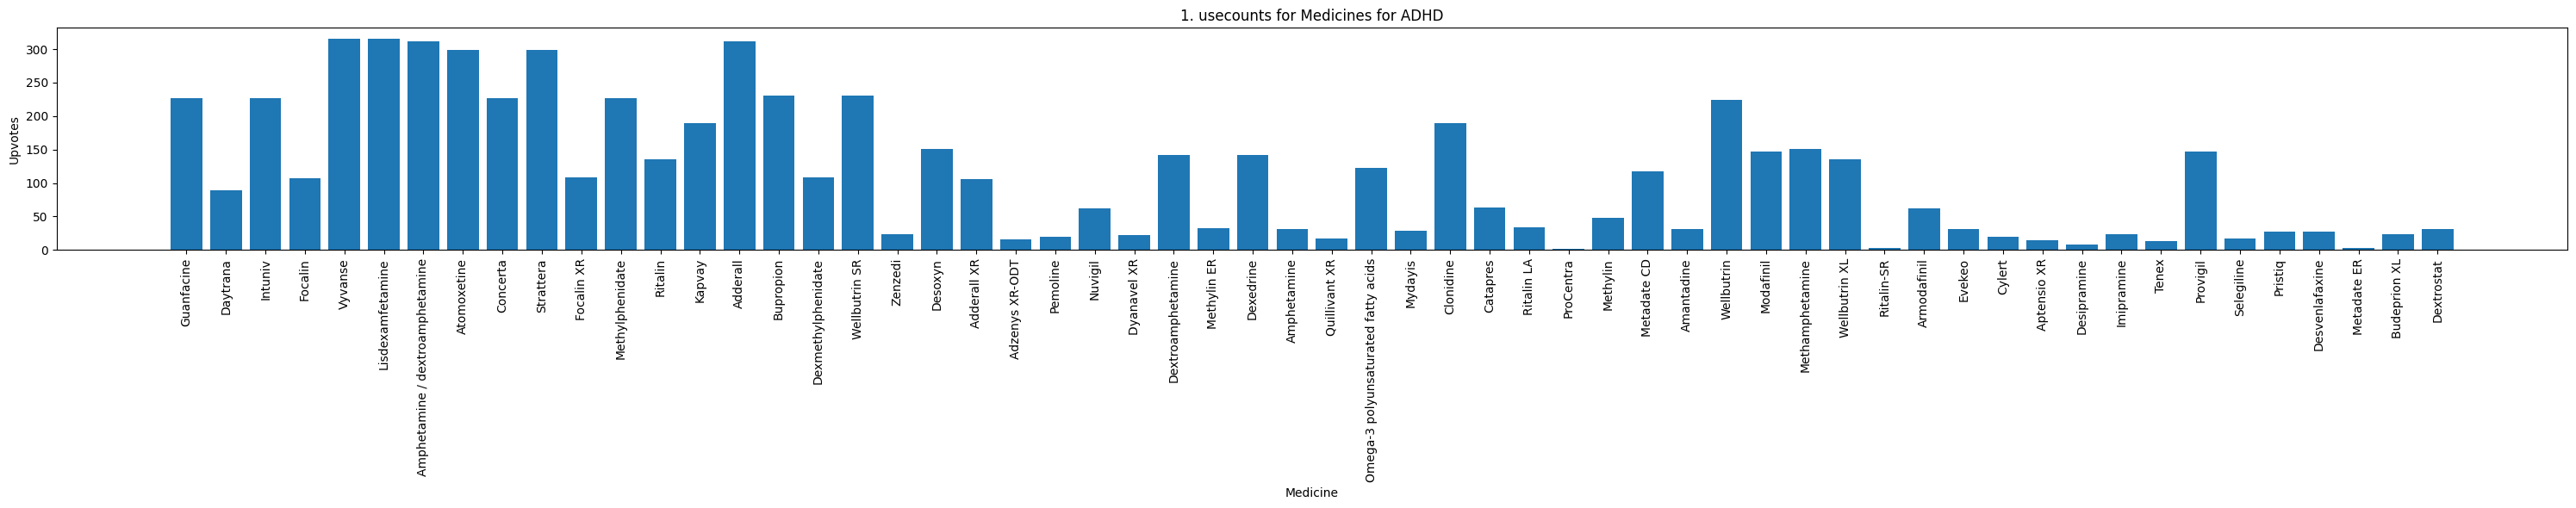

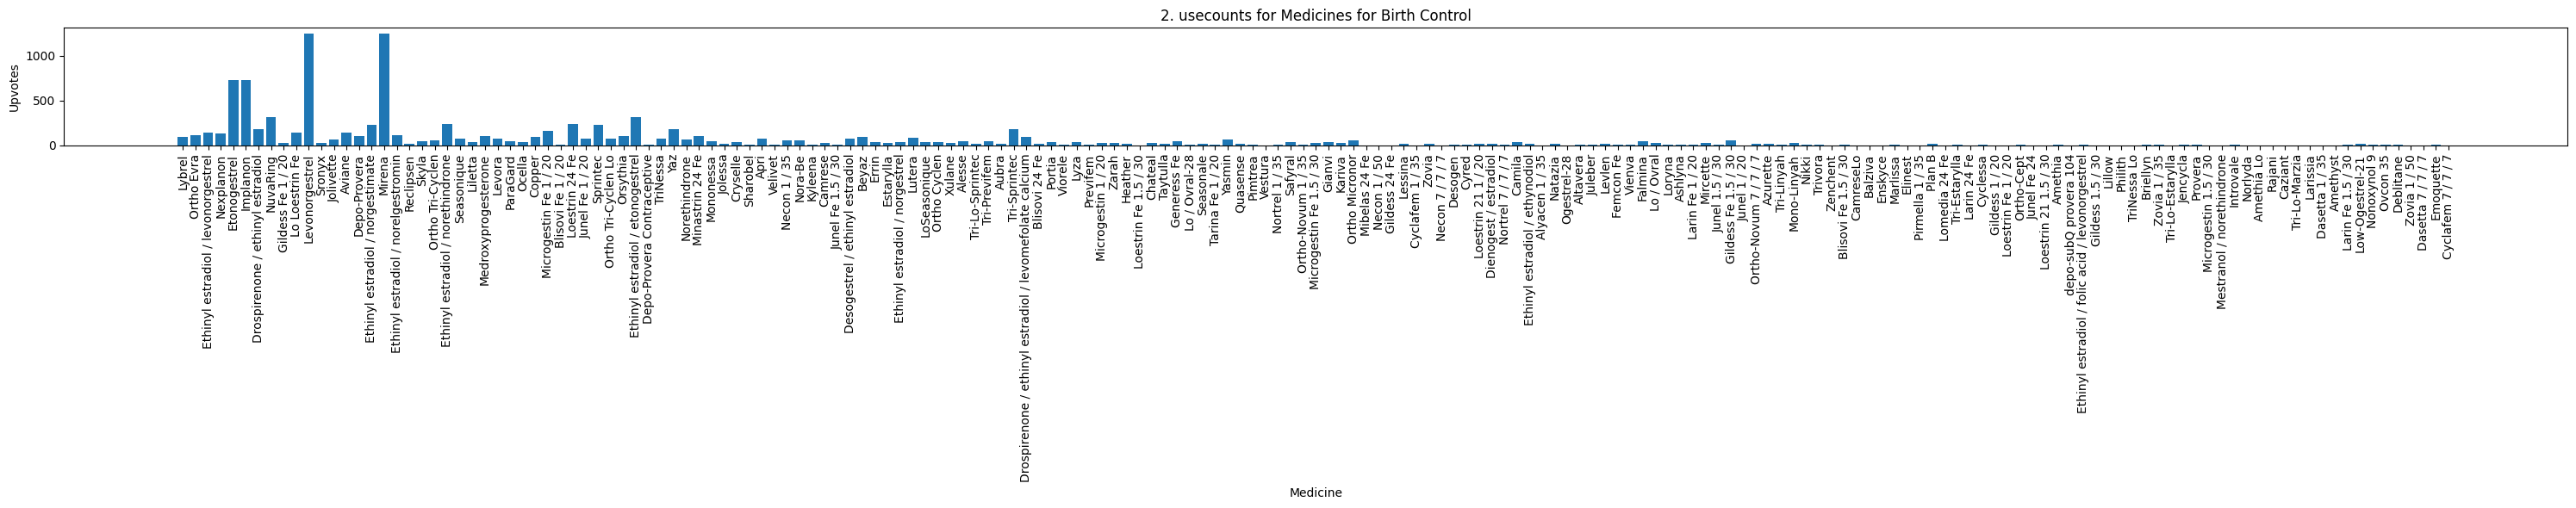

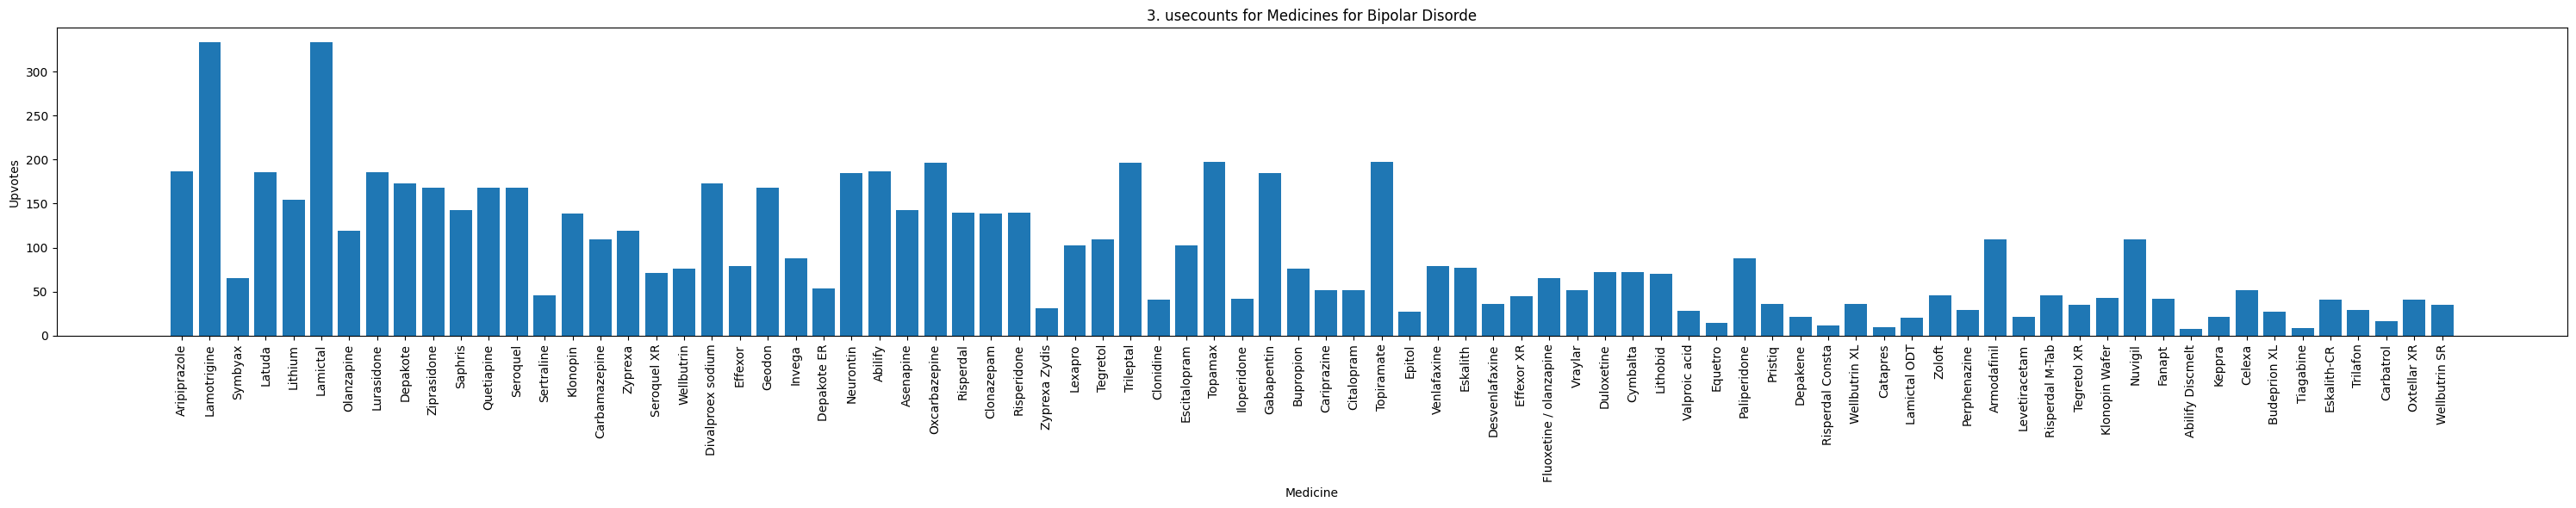

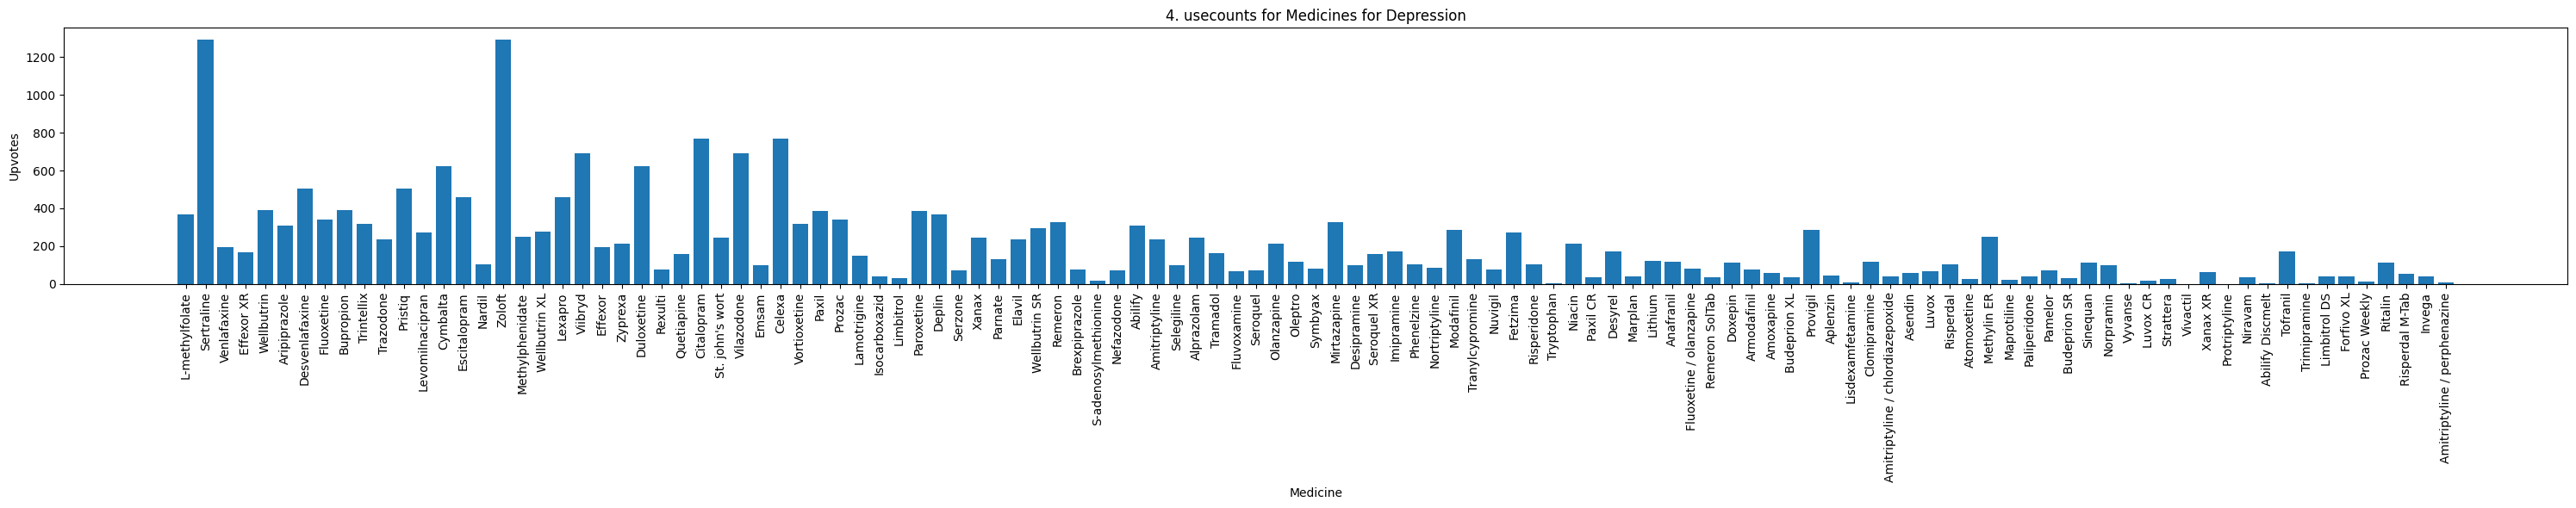

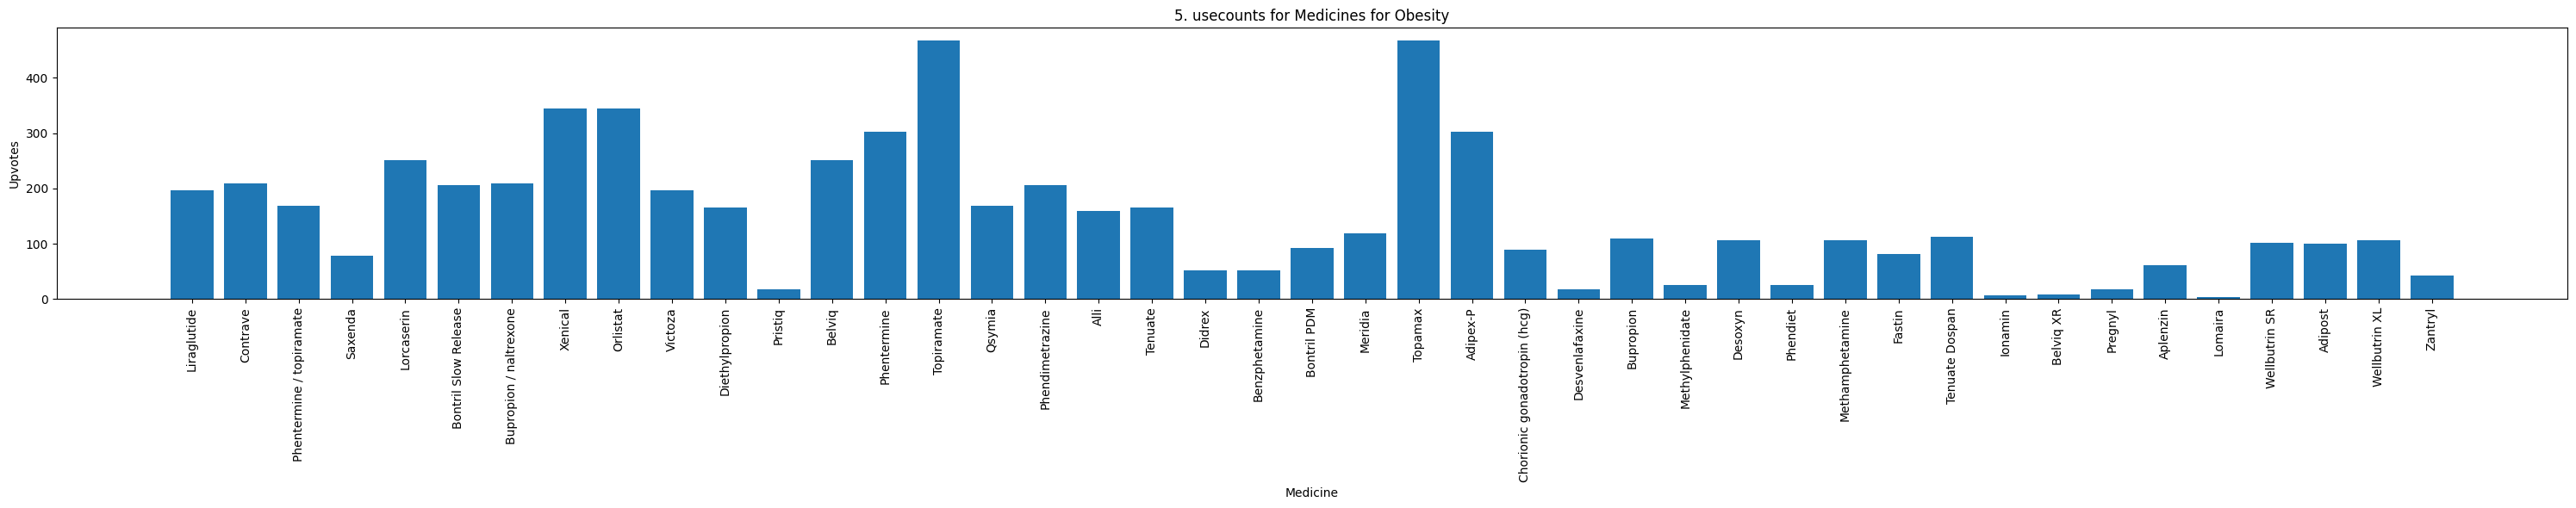

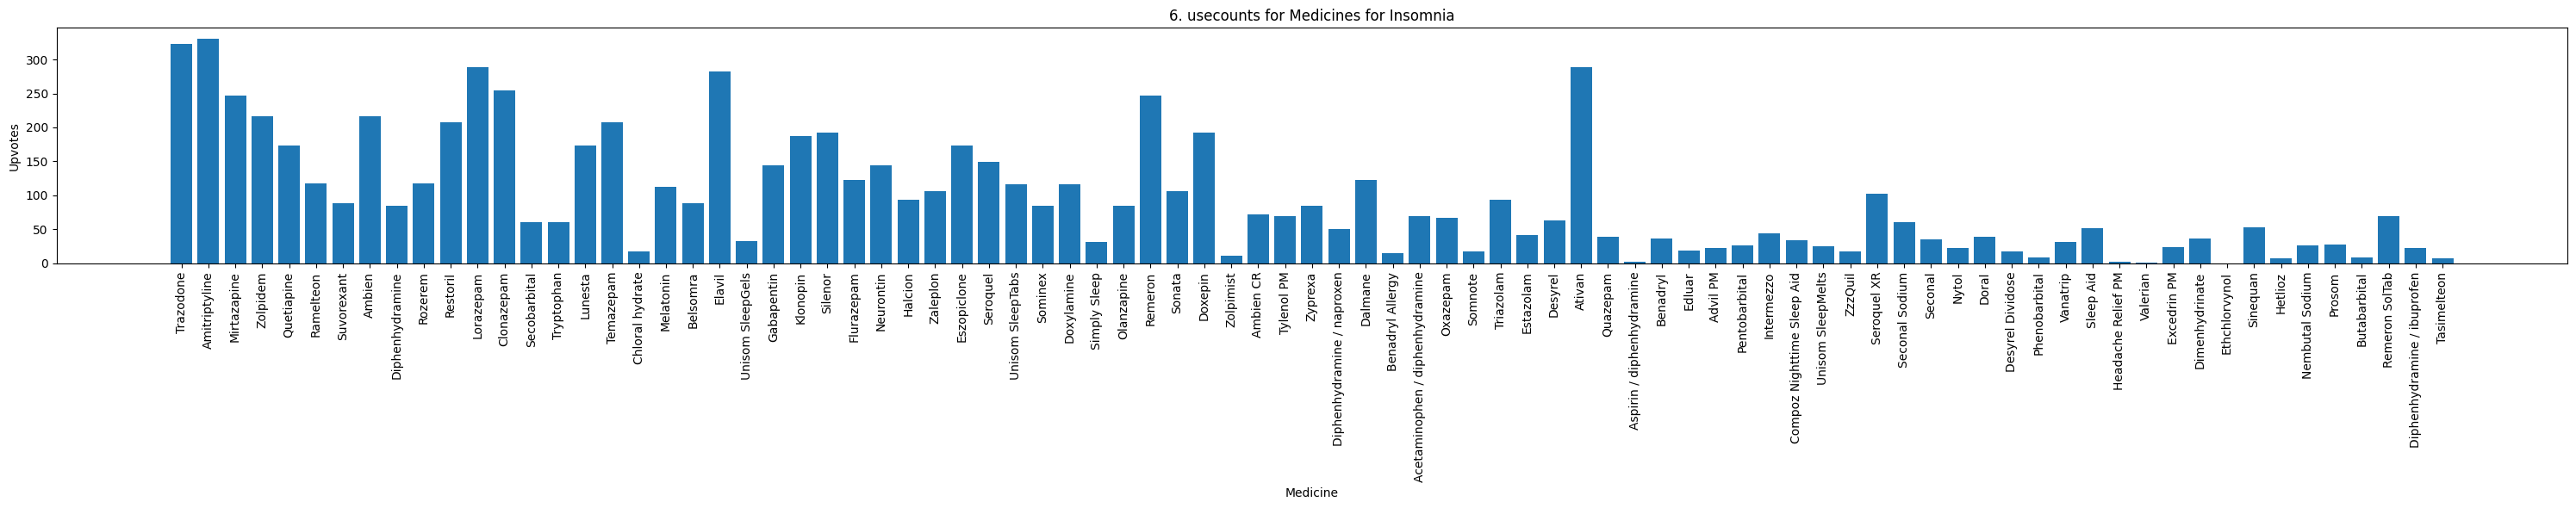

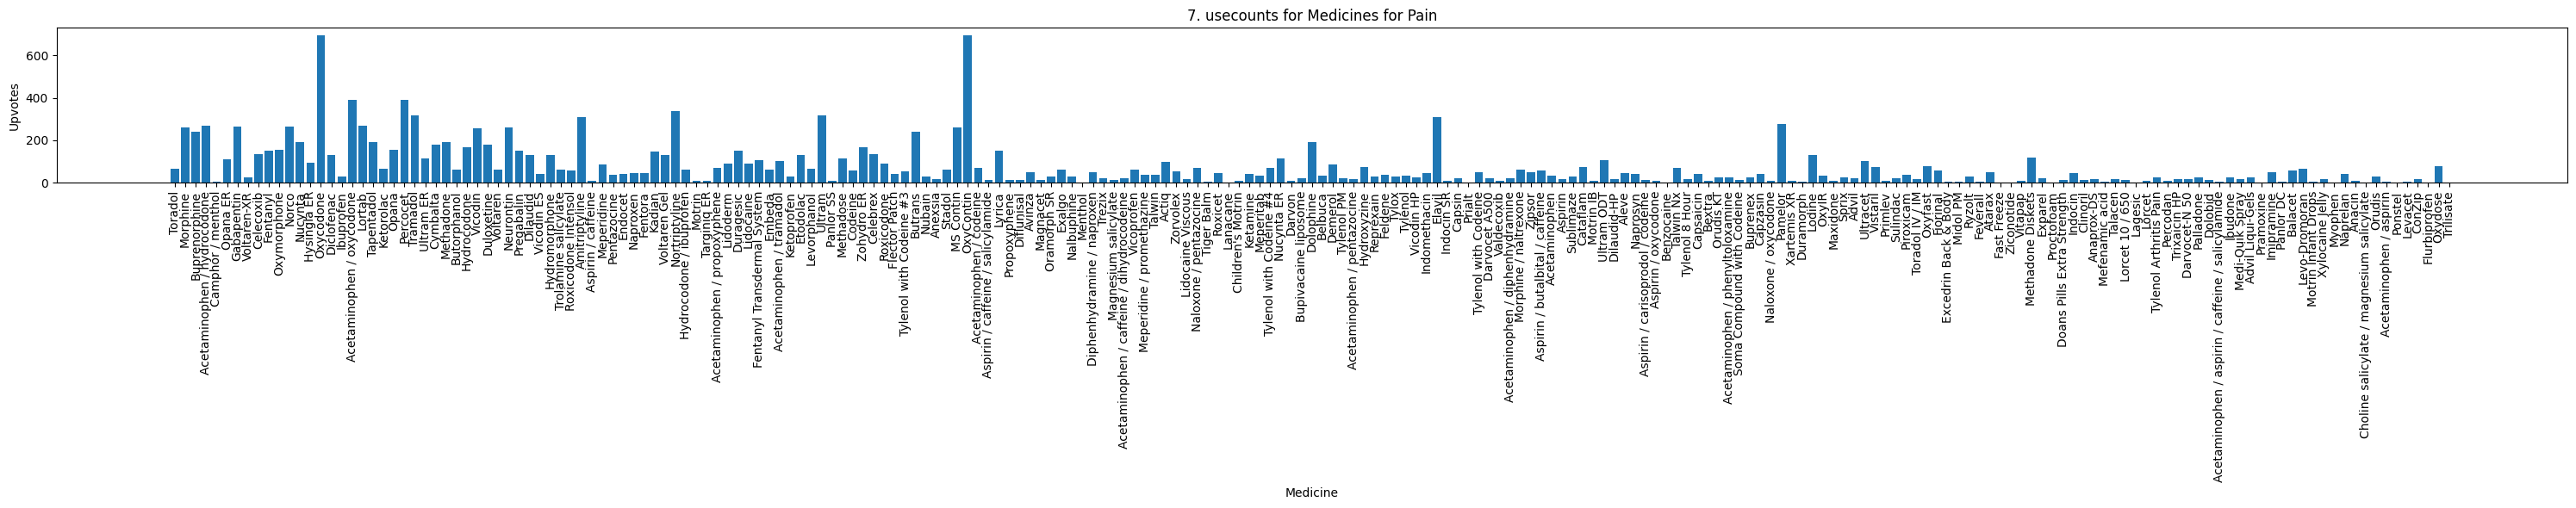

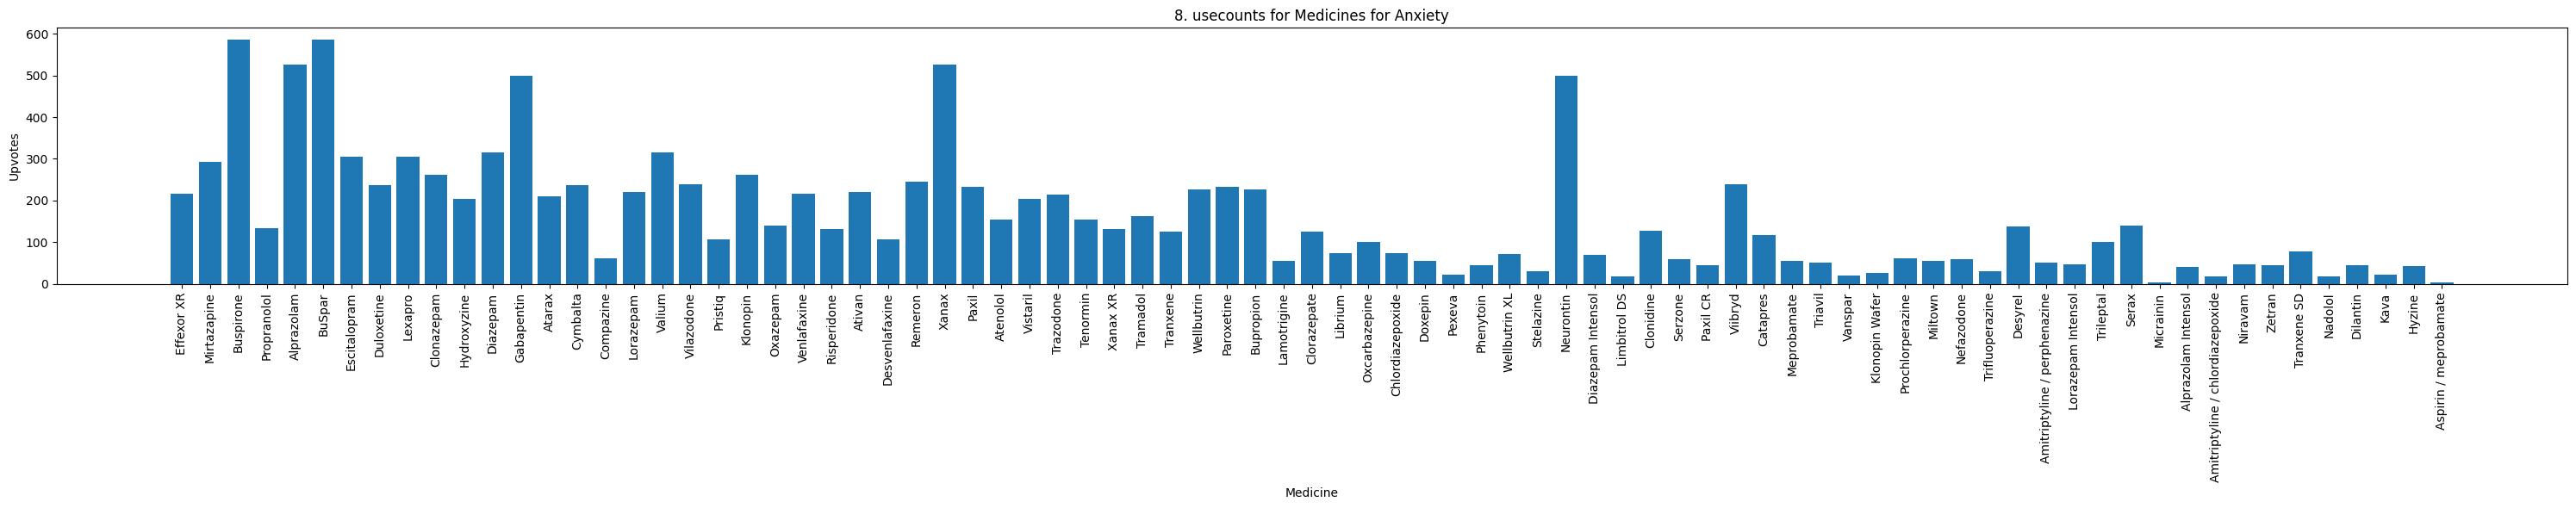

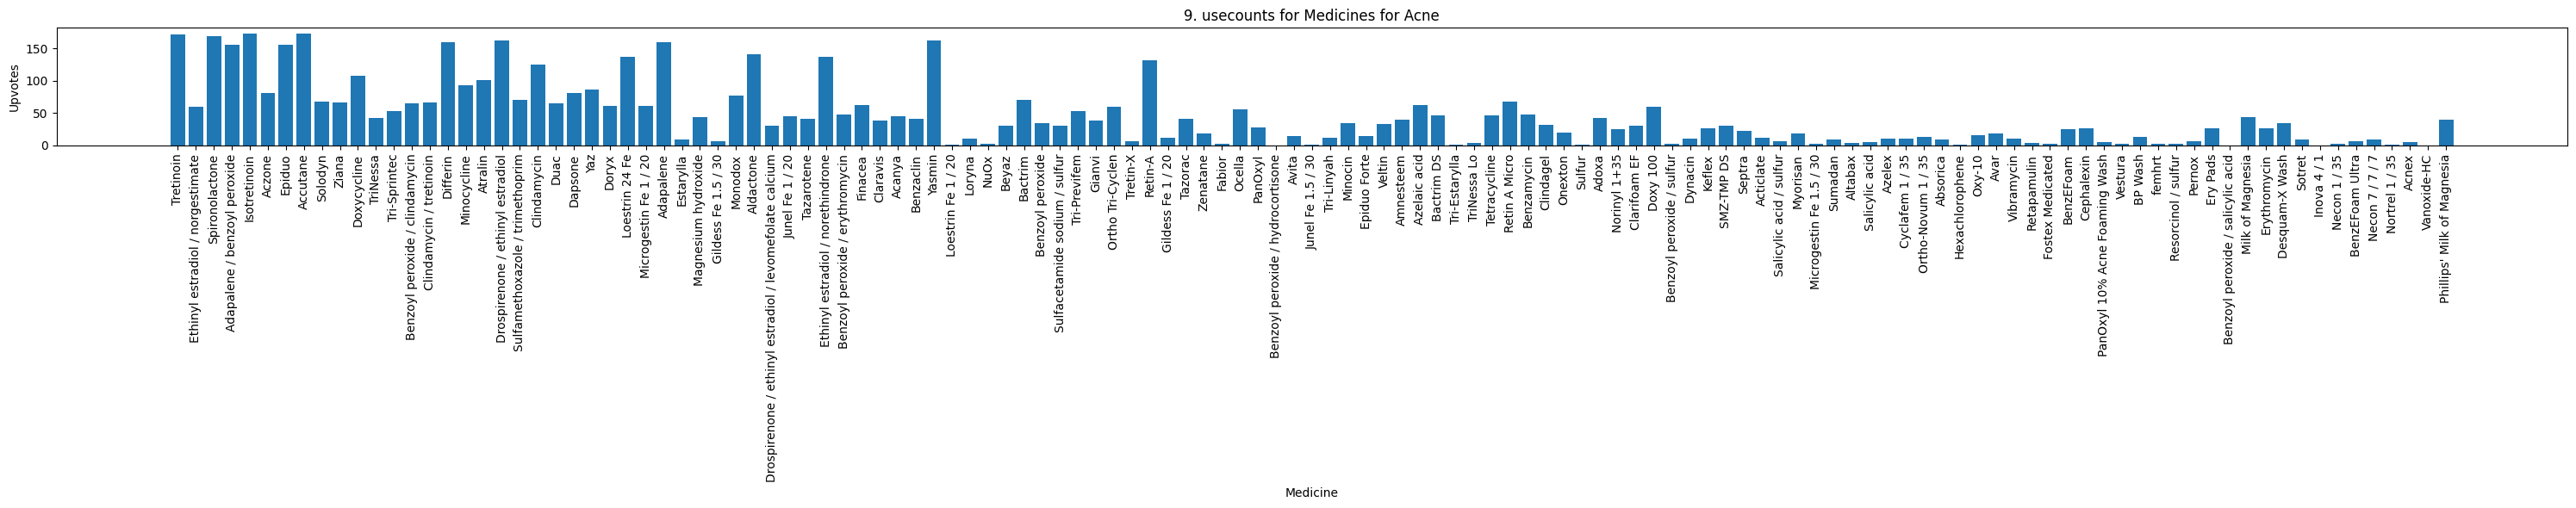

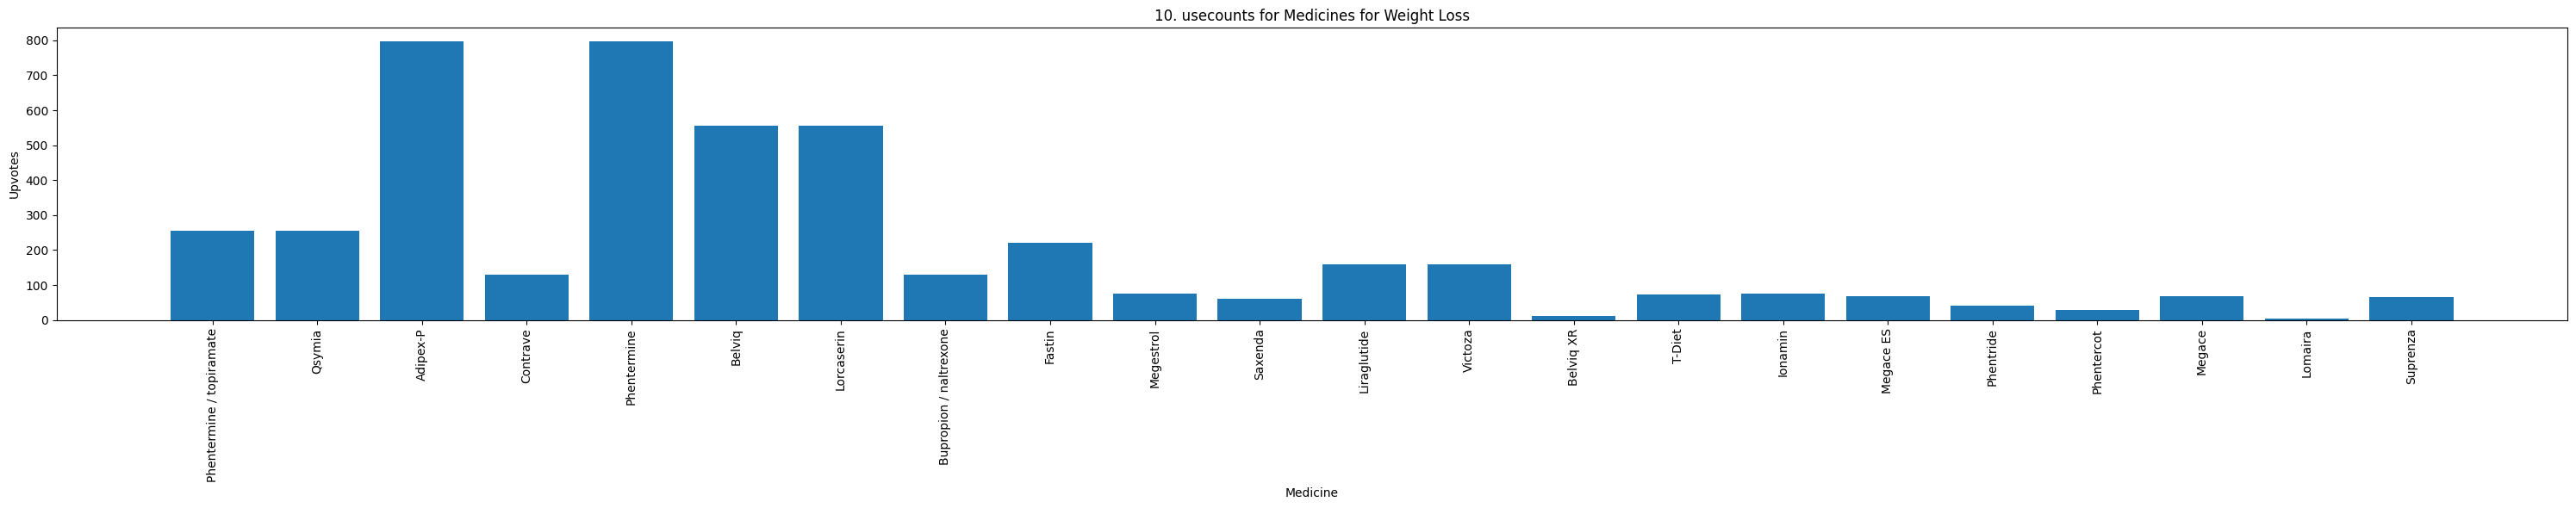

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming your dataframe is named df and has columns 'Disease', 'Medicine', and 'Upvotes'
count = 1
for disease in train_clean_df['condition'].unique():
    # Filter dataframe for the current disease
    disease_df = Data_df[Data_df['condition'] == disease]
    # Plot medicines vs. upvotes
    plt.figure(figsize=(30, 6))  # Adjust figure size as needed
    plt.bar(disease_df['drugName'], disease_df['usefulCount'])
    plt.xlabel('Medicine')
    plt.ylabel('Upvotes')
    plt.title(f'{count}. usecounts for Medicines for {disease}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    #plt.savefig(f"imgs/{disease}_counts.png")
    plt.show()
    count += 1


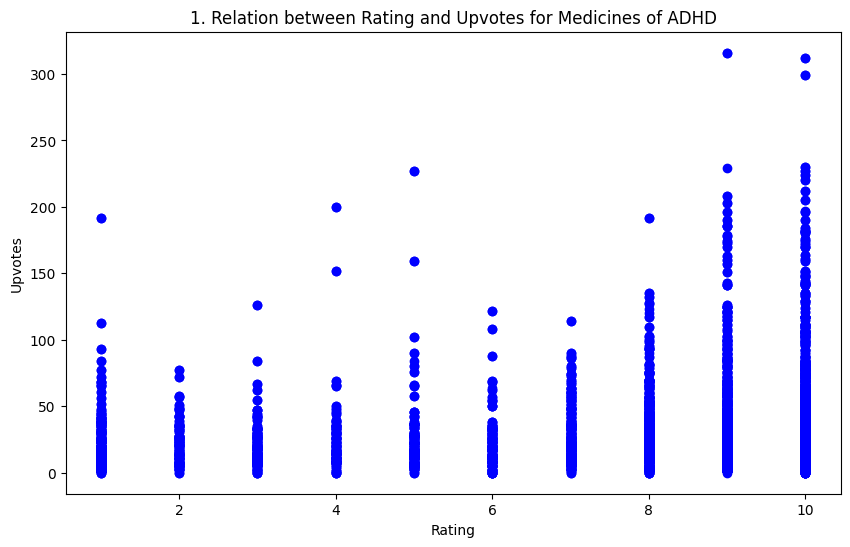

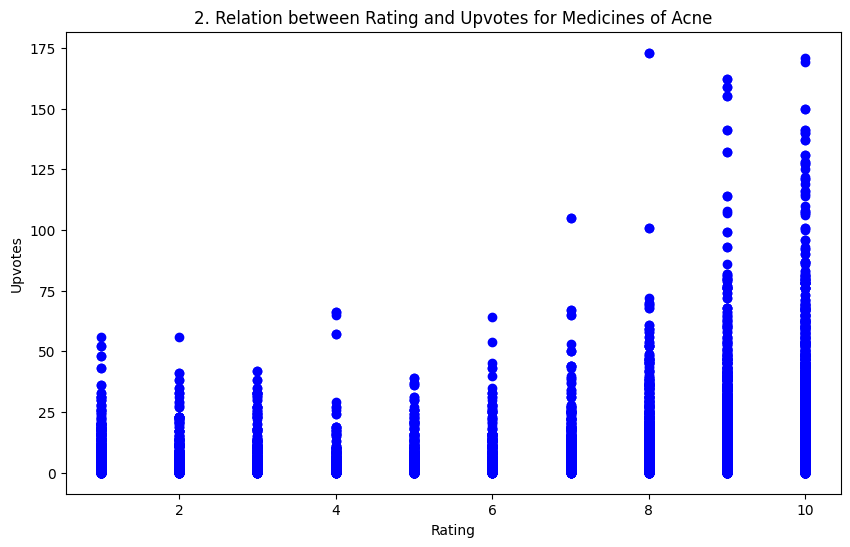

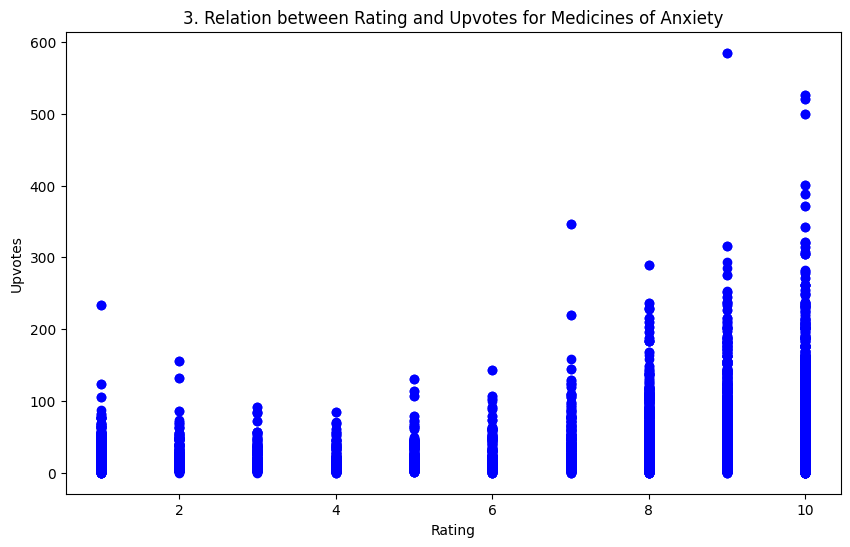

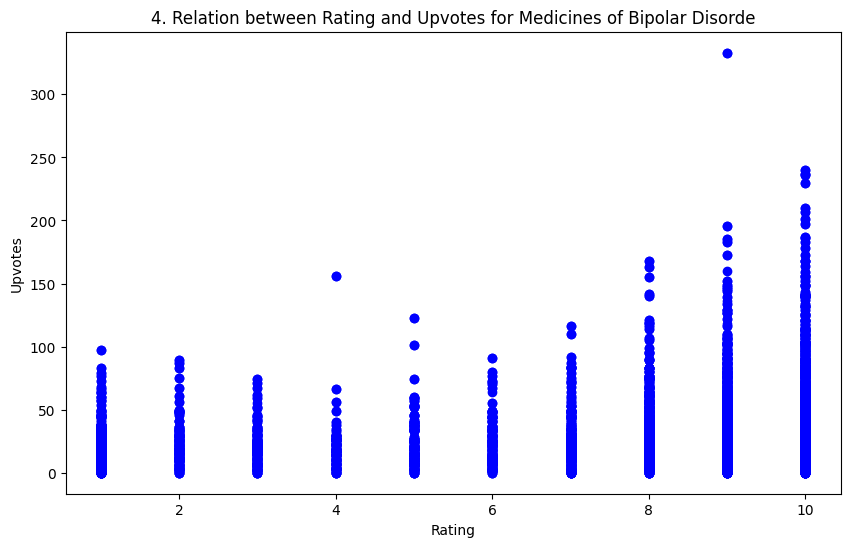

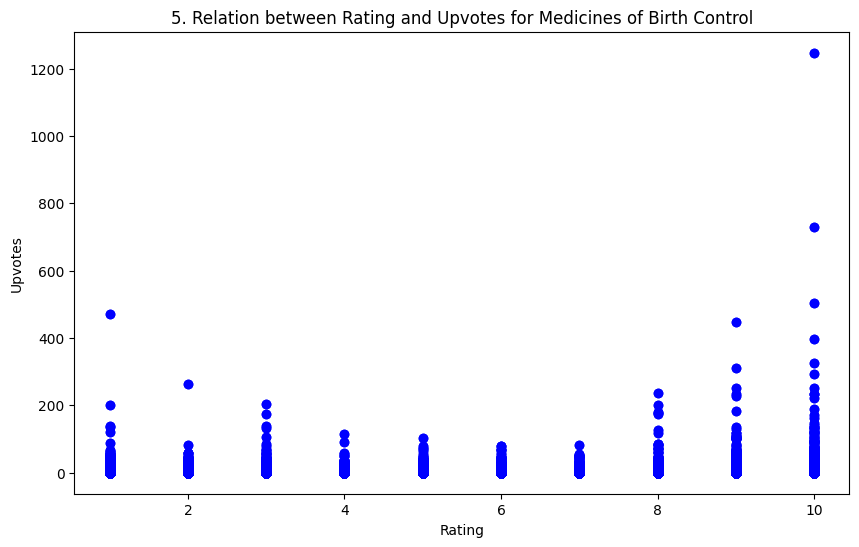

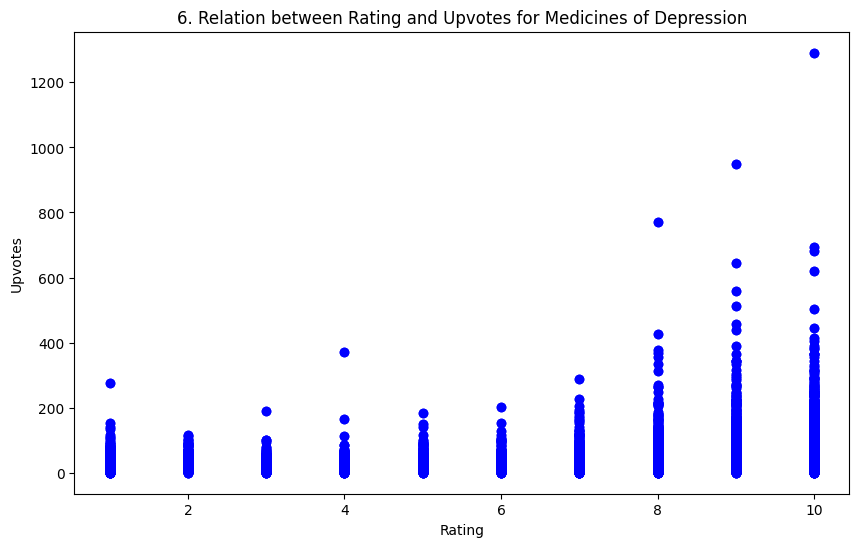

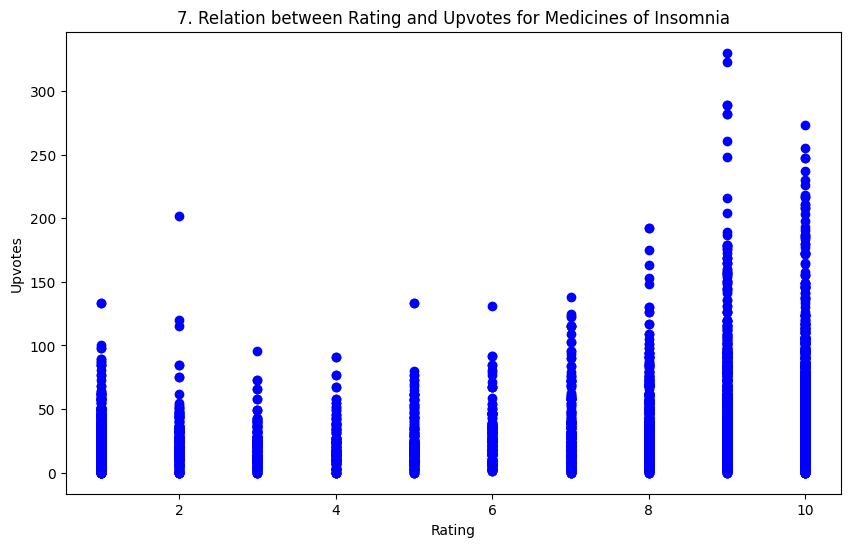

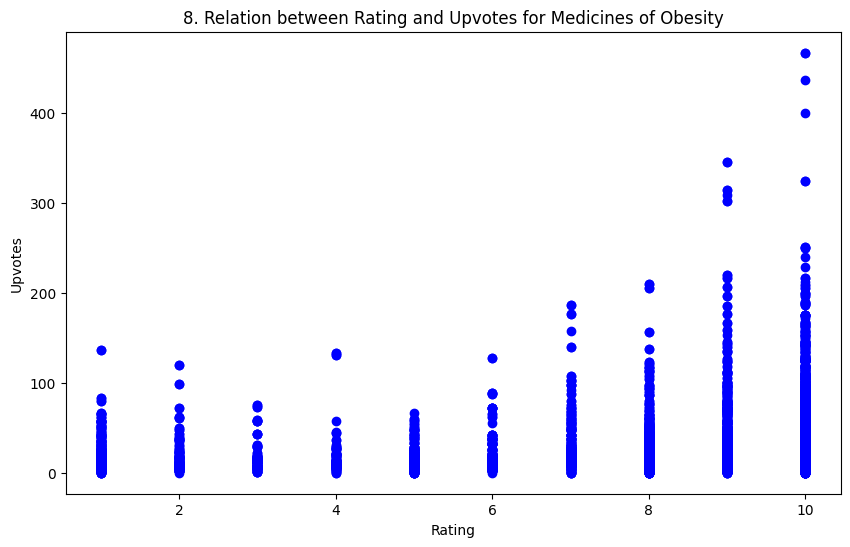

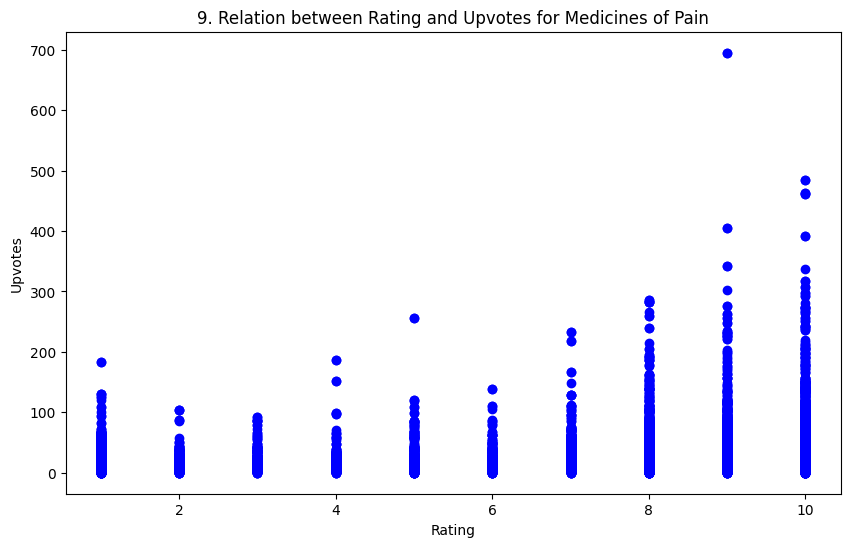

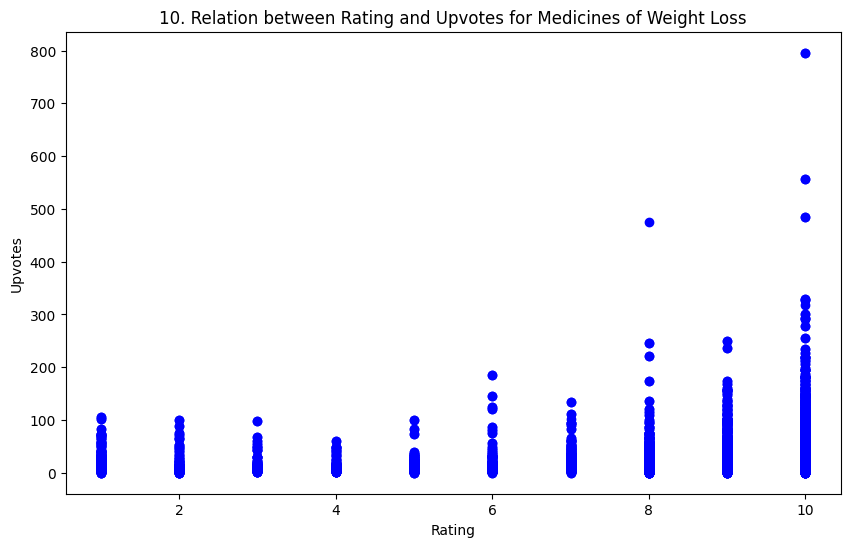

In [ ]:
count = 1

grouped_data = Data_df.loc[Data_df["condition"].isin(unique_labels)]
grouped_data = grouped_data.groupby('condition')

for condition, group_df in grouped_data:
    # Create a single plot for the current condition
    plt.figure(figsize=(10, 6))

    # Iterate over each drug for the current condition and plot the data
    for drug, drug_group_df in group_df.groupby('drugName'):
        plt.scatter(drug_group_df['rating'], drug_group_df['usefulCount'], color = 'blue')

    # Adding labels and title
    plt.xlabel('Rating')
    plt.ylabel('Upvotes')
    plt.title(f'{count}. Relation between Rating and Upvotes for Medicines of {condition}')
    count += 1
    #plt.savefig(f"img/rating/{condition}_counts_rate.jpg")
    # Showing the plot
    plt.show()



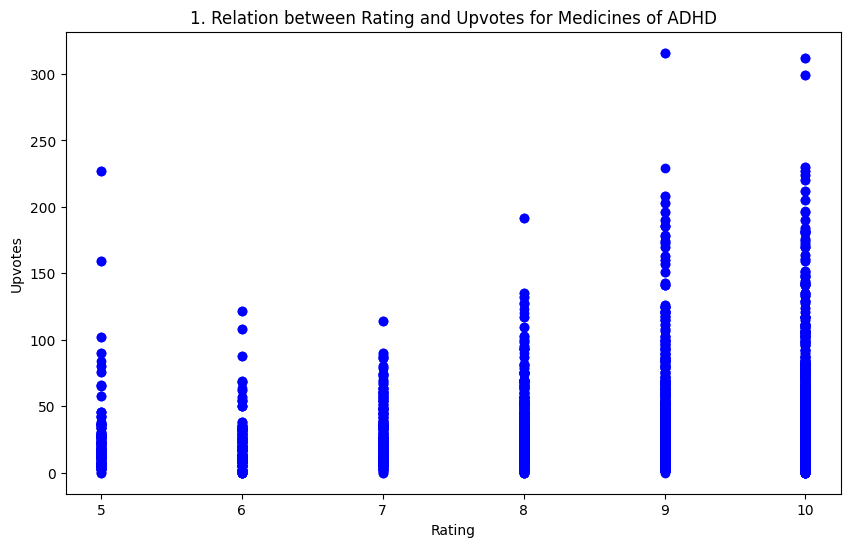

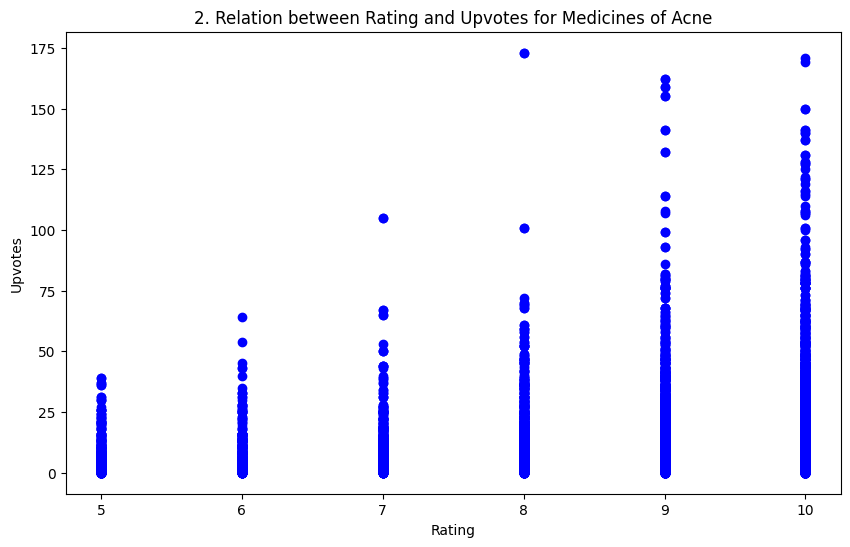

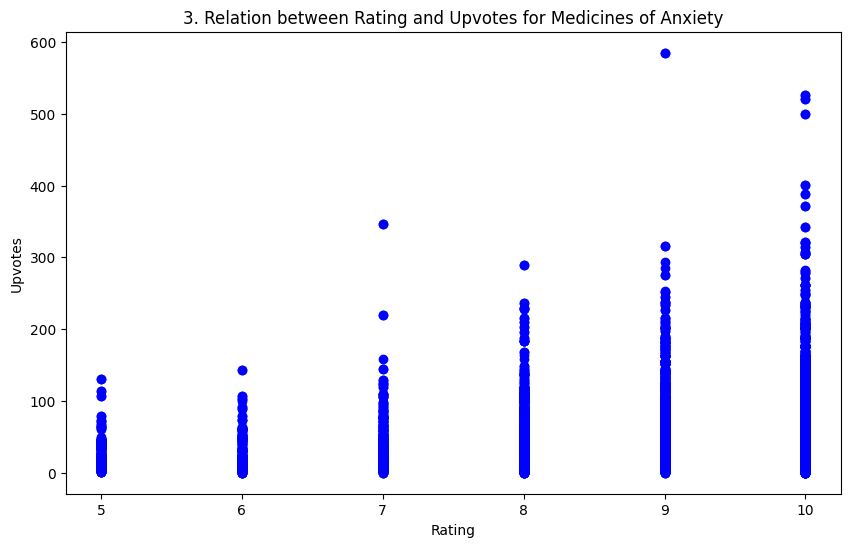

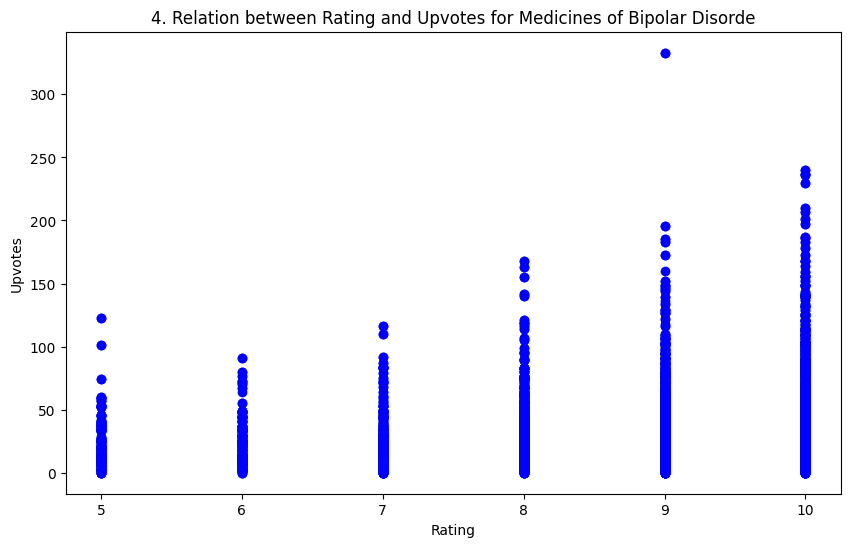

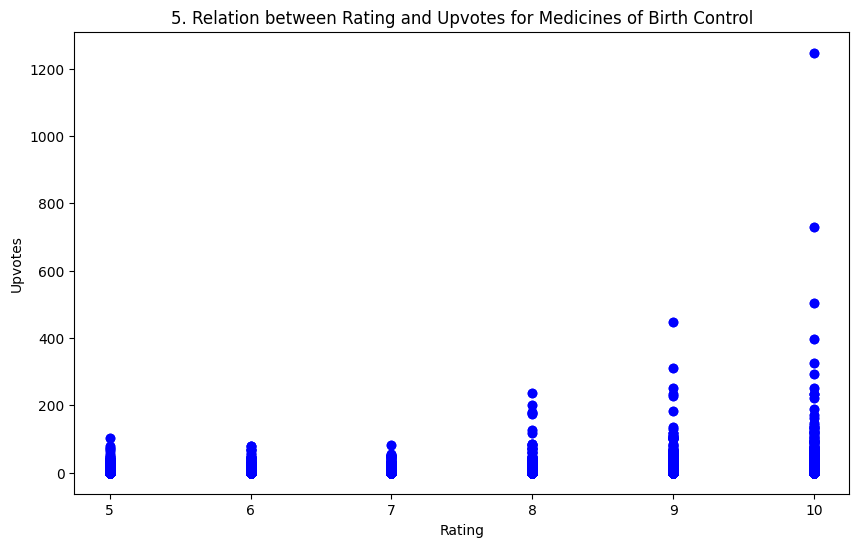

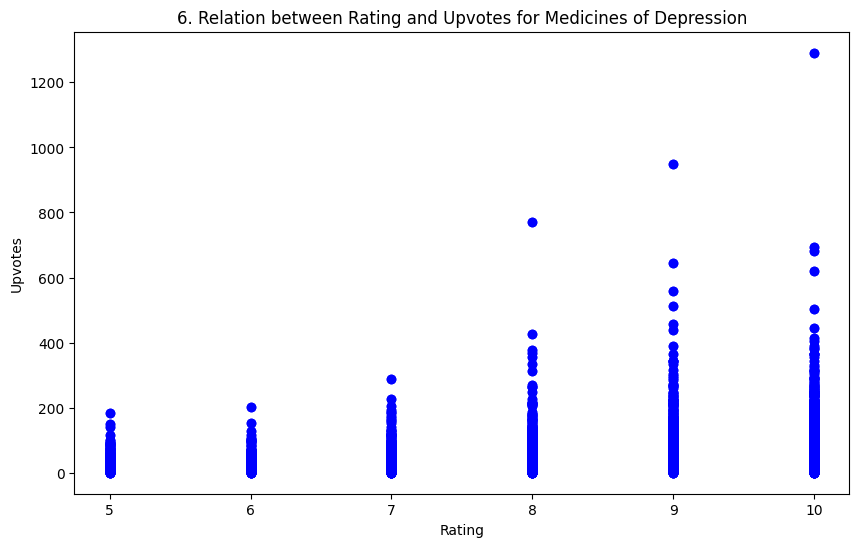

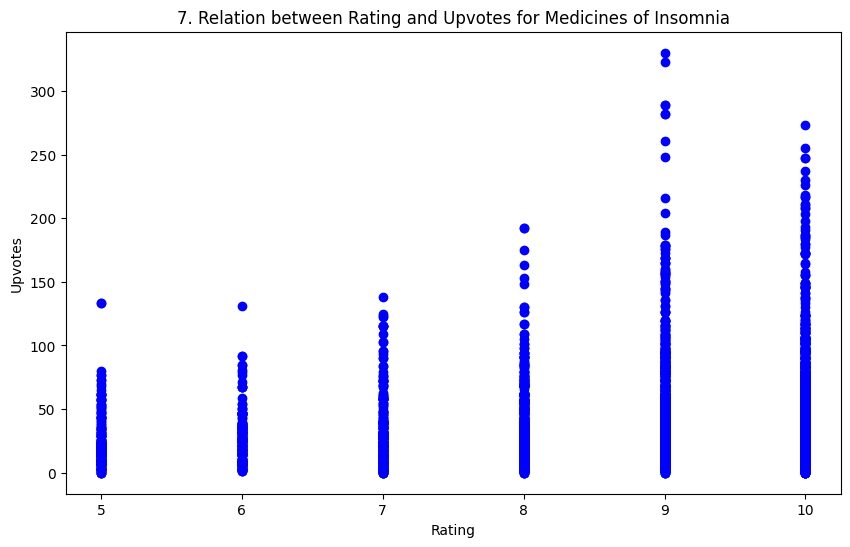

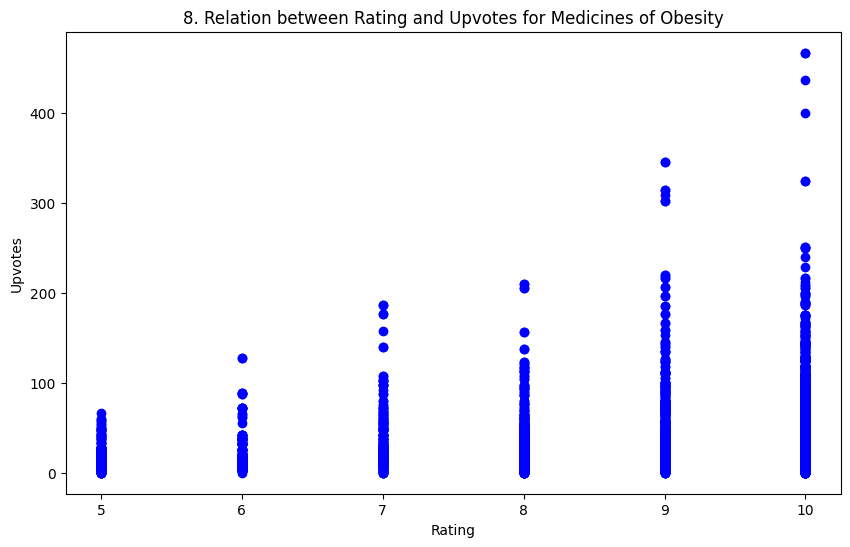

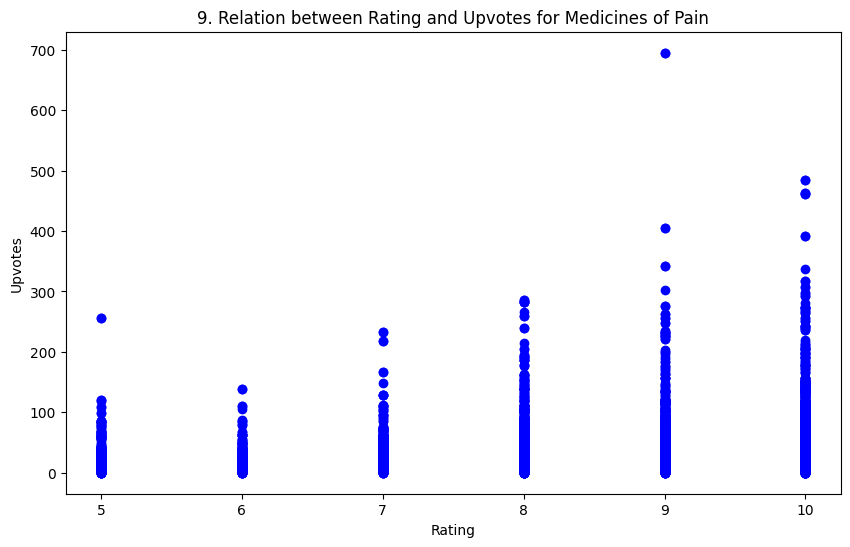

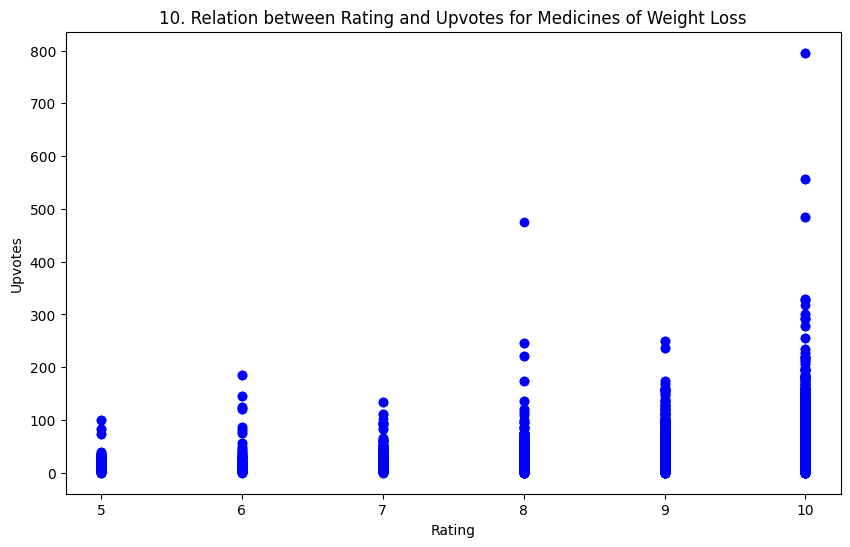

In [ ]:
count = 1

grouped_data = Data_df.loc[Data_df["condition"].isin(unique_labels)]
grouped_data = grouped_data.groupby('condition')

for condition, group_df in grouped_data:
    # Create a single plot for the current condition
    plt.figure(figsize=(10, 6))

    # Iterate over each drug for the current condition and plot the data
    for drug, drug_group_df in group_df.groupby('drugName'):
        drug_group_df = drug_group_df[drug_group_df['rating']>=5]
        plt.scatter(drug_group_df['rating'], drug_group_df['usefulCount'], color = 'blue')

    # Adding labels and title
    plt.xlabel('Rating')
    plt.ylabel('Upvotes')
    plt.title(f'{count}. Relation between Rating and Upvotes for Medicines of {condition}')
    count += 1
    #plt.savefig(f"img/{condition}_counts_rate5.png")
    # Showing the plot
    plt.show()



In [ ]:
!zip -r /content/imgs.zip /content/imgs

	zip warning: name not matched: /content/imgs

zip error: Nothing to do! (try: zip -r /content/imgs.zip . -i /content/imgs)


In [ ]:
# Function to get the top drugs for given condtion
def top_3(condition):
  #filtering Data to the condtion
  drug_lst = Data_df[Data_df['condition']==condition]

  #getting most useful counts
  useful_rev=drug_lst[drug_lst['usefulCount']>=150].drop(['uniqueID','usefulCount'],axis=1)

  #Averaging rating of each drug based on useful counts
  averaged_ratings = useful_rev.groupby('drugName').mean('rating')

  # sorting by rating and useful counts
  sorted_meds = averaged_ratings.sort_values(by = ['rating'],ascending=[False]).reset_index() # reseting index to be able to read coloumn name

  #Getting top 3 meds
  best = sorted_meds['drugName'].head(3).tolist()

  return  best

In [ ]:
# Examble for recomendation per condtion
top_3("ADHD")

['Adderall', 'Amphetamine / dextroamphetamine', 'Wellbutrin']

## DistilBert Model


### Intializing Model

In [ ]:
import torch
import transformers
from transformers import DistilBertModel

In [ ]:
# Setting up Hyperparameters
EPOCHS = 1
LEARNING_RATE = 1e-05

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.Linear = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768,len(unique_labels))

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.Linear(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistillBERTClass()
model.to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
#if running on CPU
#checkpoint = torch.load("/content/drive/MyDrive/KBAI model/pytorch_distilbert_drugs.bin",map_location=torch.device('cpu'))

# Load last saved model and optimizer states
checkpoint = torch.load("/content/drive/MyDrive/KBAI model/pytorch_distilbert_drugs.bin")

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# Function to calcuate the accuracy of the model

def Accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

### Training

In [ ]:
def train(epoch):
    tr_loss = 0 # stores accumelative training loss
    n_correct = 0 # stores number of accurate predicions
    nb_tr_steps = 0 # stores number of training steps
    nb_tr_examples = 0 # stores number of samples passed through model at a given time

    model.train() #set model on training mode
    for _,data in enumerate(training_loader, 0):
       # Retrieve token IDs,attention masks and targets from dataloader
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        #passes ids and attention masks through Model
        outputs = model(ids, mask)

        # Uses cross entropy loss to calculate loss between output and target predictions
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() # accumelates loss

        #Applying softmax function on output and calculate number of correct predictions
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += Accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad() #Clears gradient of parameters of latest minibatch to avoid gradient accumilations
        loss.backward() # performs backwards propogation on model parameters using calculated loss
        optimizer.step() # performs optimization step on model

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

Training Loss per 5000 steps: 0.007858235388994217
Training Accuracy per 5000 steps: 100.0
Training Loss per 5000 steps: 0.047373638720475134
Training Accuracy per 5000 steps: 98.44281143771246
The Total Accuracy for Epoch 0: 98.3340319941583
Training Loss Epoch: 0.05022412426251853
Training Accuracy Epoch: 98.3340319941583


### Validation

In [ ]:
y_pred = []
y_true = []
def valid(model, testing_loader):
    tr_loss = 0
    n_correct = 0
    n_wrong = 0
    nb_tr_steps=0
    nb_tr_examples=0

    model.eval()
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += Accuracy(big_idx, targets)

            y_pred.extend(big_idx.data.cpu().numpy())
            y_true.extend(targets.data.cpu().numpy())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

Validation Loss per 100 steps: 7.265531894518062e-05
Validation Accuracy per 100 steps: 100.0
Validation Loss per 100 steps: 0.29965192528076373
Validation Accuracy per 100 steps: 93.36132773445311
Validation Loss Epoch: 0.29859120686196444
Validation Accuracy Epoch: 93.2827385758114
Accuracy on test data = 93.28%


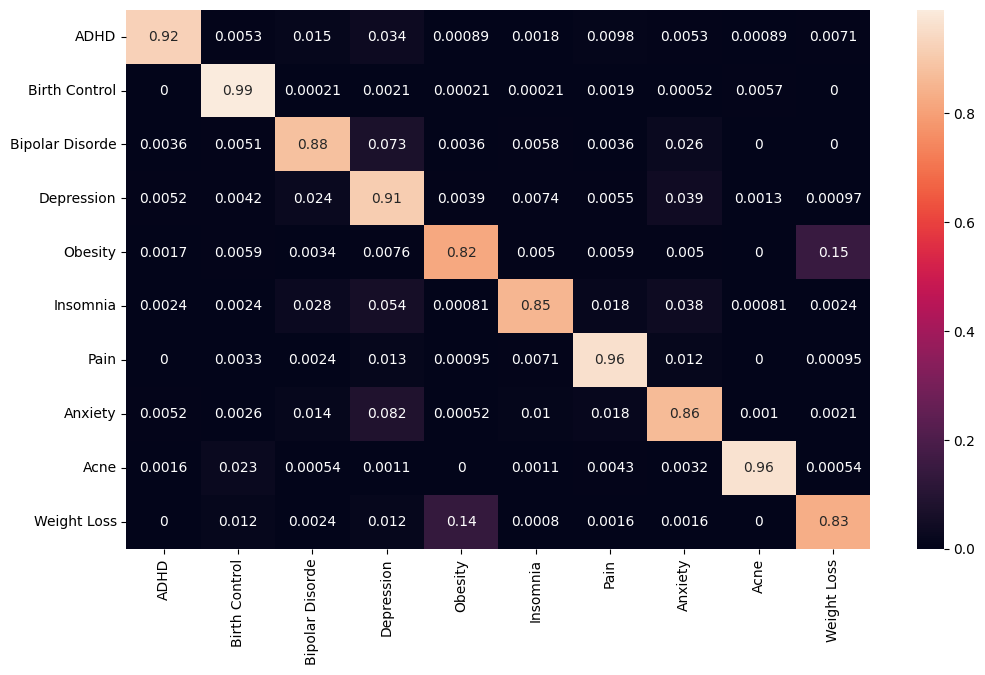

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in unique_labels],
                     columns = [i for i in unique_labels])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

### Inference

In [ ]:
def inference(model,text):
    clean_text = preprocess(text) # preprocess data to pass it into tokenizer

    model.eval()

    #tokenizing text to process it into model
    input = tokenizer.encode_plus(
            clean_text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
    #transform data into tensor objects
    ids = torch.tensor(input['input_ids'], dtype=torch.long)
    mask = torch.tensor(input['attention_mask'], dtype=torch.long)

    with torch.no_grad():
      ids = ids.to(device, dtype = torch.long)
      mask = mask.to(device, dtype = torch.long)
      output = model(ids, mask)
      _,index=torch.max(output.data, dim=1)

    value = {i for i in value_pair if value_pair[i]==index.item()}

    return value.pop()

### Saving Model

In [ ]:
output_model_file = '/content/drive/MyDrive/KBAI model/pytorch_distilbert_drugs.bin'

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, output_model_file)

## Recommendation System Application

In [ ]:
def Recommendation(text):
  condition=inference(model,text)
  meds=top_3(condition)
  print("Condition: ",condition)
  print("\nTop 3 recommended Medications:\n1. "+meds[0]+"\n2. "+meds[1],"\n3. "+meds[2])

Recommendation("I just got the copper IUD removed after having it for 7 months. I am normally a really positive person with a happy demeanor and I am convinced that the copper IUD threw me into depression and anxiety. I have NEVER had depression or anxiety, and every month my moods got worse, I would cry almost everyday, I would snap at my bf or family for the smallest thing, and I felt rage almost all the time. I was trying to figure out if something else in my life was affecting me, I even went to my therapist and a depression care specialist. I finally read some reviews on the copper IUD and depression and it seems pretty common. Drs will tell you it&#039;s not the IUD but please trust your intuition. I also had yeast infection &amp; BV almost every month because of IUD.")

Condition:  Birth Control

Top 3 recommended Medications:
1. Microgestin Fe 1 / 20
2. Ethinyl estradiol / norgestimate 
3. Sprintec
